In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os

In [3]:
from glob import glob
import cv2
import tensorflow as tf

In [4]:
from PIL import Image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetV2B0, MobileNetV2
from tensorflow.keras.optimizers import Optimizer, Adam
from tensorflow.keras.utils import load_img
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import plot_model

# Loading images 

Some information about the dataset is included here for clarity:

This dataset contains around 25k images of size 150x150 distributed under 6 categories.

{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

In [5]:
train_path = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
test_path = '/kaggle/input/intel-image-classification/seg_test/seg_test/'
pred_path = '/kaggle/input/intel-image-classification/seg_pred/seg_pred/'

In [14]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.25,
                                  validation_split=0.2,
                                  width_shift_range=0.15,
                                  height_shift_range=0.15,
                                  horizontal_flip = True,  
                                  vertical_flip = False,
                                  fill_mode='nearest')

# Generate the train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=128,
    subset='training',
    shuffle=True,
    class_mode="categorical",
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=128,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate the train and validation generators
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=128,
    shuffle=False,
    class_mode="categorical",
)

Found 3000 images belonging to 6 classes.


In [16]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes \n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes 

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


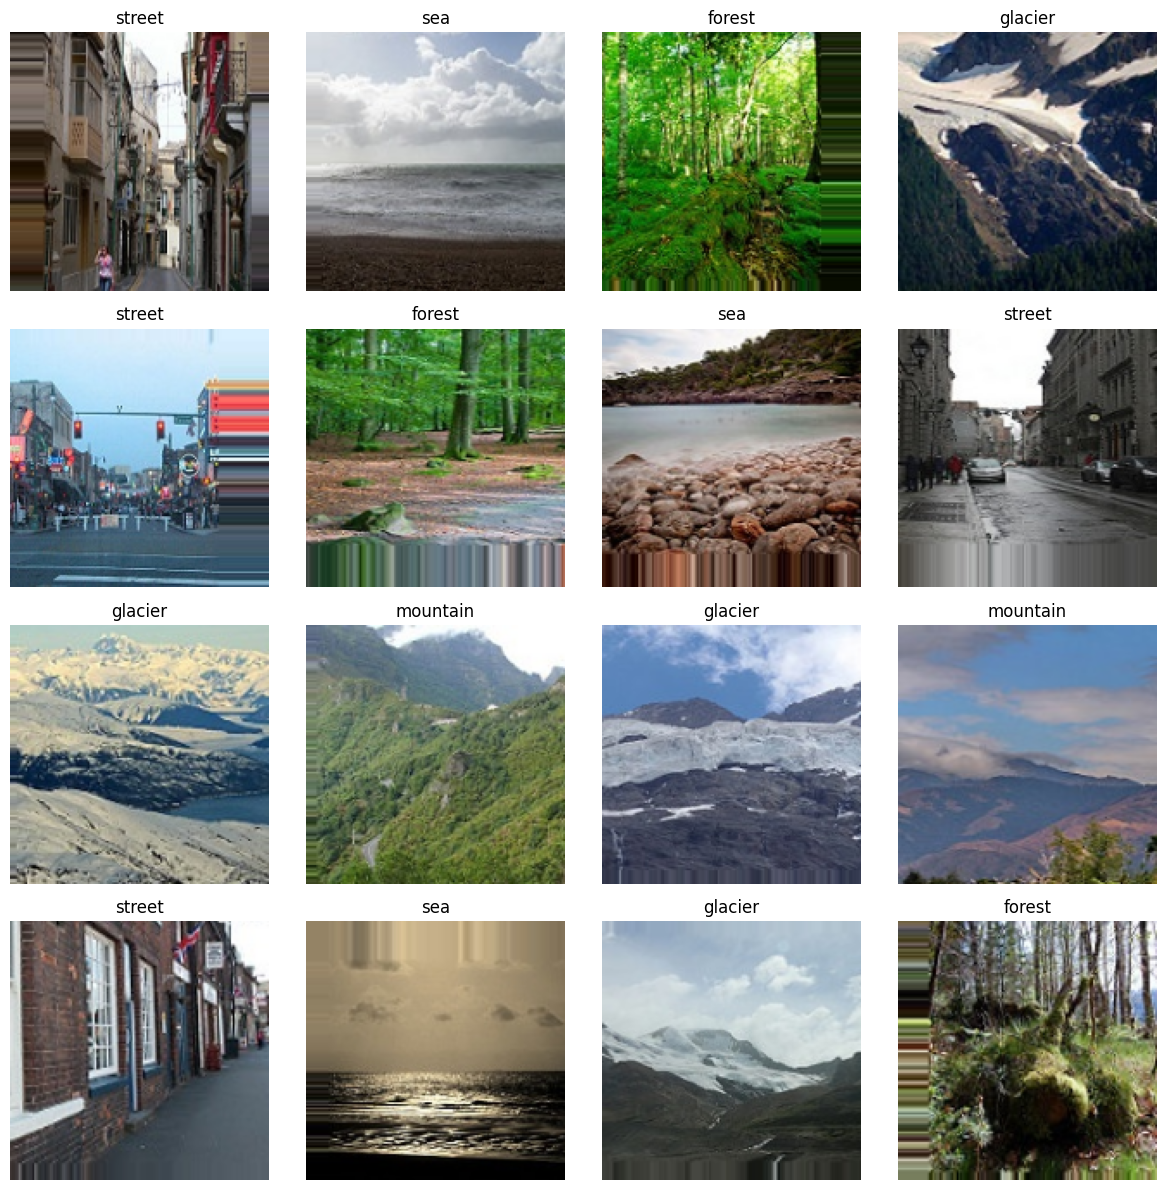

In [17]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
idx = 0

for i in range(4):
    for j in range(4):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

# Pre-trained VGG16 model

In [11]:
base_VGG16 = VGG16(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

#make all layer in the pretrained VGG16 non-trainable 
for layer in base_VGG16.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
inputs = Input(shape=(150, 150, 3))
x = base_VGG16(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation='softmax')(x)

model_vgg16 = Model(inputs, x)
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                             

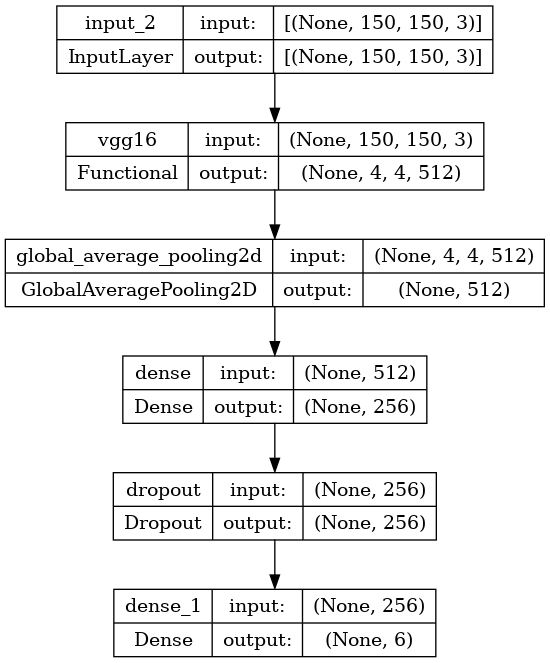

In [18]:
plot_model(model_vgg16, show_shapes=True)

In [19]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.ckpt',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4,
        restore_best_weights=True
    ),
]

model_vgg16.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model_vgg16.fit(train_generator, validation_data = val_generator, epochs=20,
                callbacks=callbacks)

Epoch 1/20
88/88 [==============================] - 91s 1s/step - loss: 0.5627 - accuracy: 0.7934 - val_loss: 0.5525 - val_accuracy: 0.7857
Epoch 2/20
88/88 [==============================] - 91s 1s/step - loss: 0.5142 - accuracy: 0.8069 - val_loss: 0.5161 - val_accuracy: 0.8021
Epoch 3/20
88/88 [==============================] - 89s 1s/step - loss: 0.4886 - accuracy: 0.8161 - val_loss: 0.5013 - val_accuracy: 0.8153
Epoch 4/20
88/88 [==============================] - 89s 1s/step - loss: 0.4728 - accuracy: 0.8264 - val_loss: 0.5122 - val_accuracy: 0.8121
Epoch 5/20
88/88 [==============================] - 90s 1s/step - loss: 0.4596 - accuracy: 0.8321 - val_loss: 0.4866 - val_accuracy: 0.8206
Epoch 6/20
88/88 [==============================] - 89s 1s/step - loss: 0.4479 - accuracy: 0.8325 - val_loss: 0.4707 - val_accuracy: 0.8210
Epoch 7/20
88/88 [==============================] - 89s 1s/step - loss: 0.4430 - accuracy: 0.8337 - val_loss: 0.4714 - val_accuracy: 0.8203
Epoch 8/20
88/88 [==

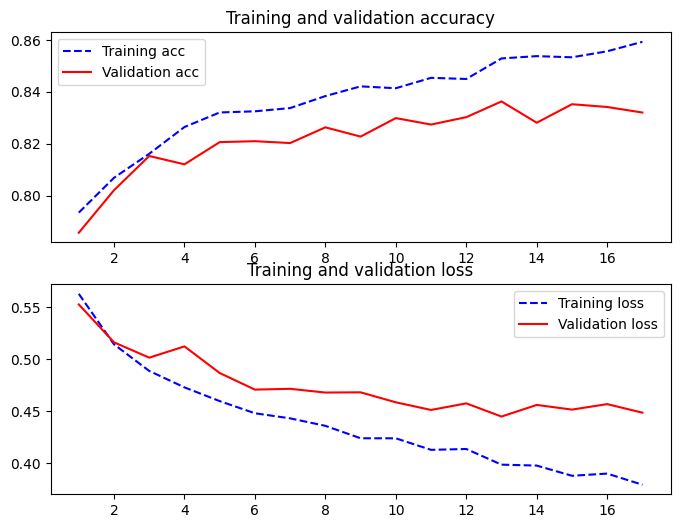

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(2, 1, figsize = (8, 6))

epochs = range(1, len(acc) + 1)
ax[0].plot(epochs, acc, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [21]:
pred_vgg16 = model_vgg16.predict(test_generator)
y_test = test_generator.classes
y_pred_vgg16 = np.argmax(pred_vgg16, axis=1)

24/24 [==============================] - 27s 1s/step


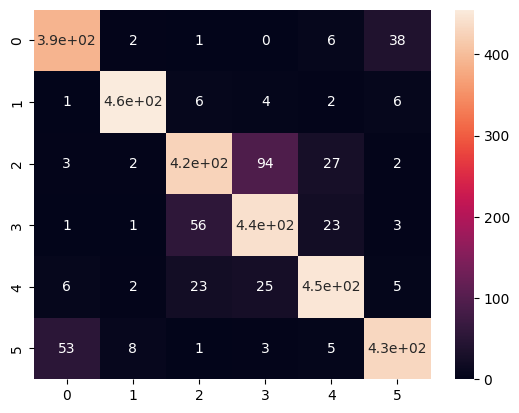

In [23]:
sns.heatmap(confusion_matrix(y_test,y_pred_vgg16),
            annot=True)
plt.show()